In [1]:
import torch

if torch.cuda.is_available():      
    #device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [1]:
from transformers import TFBertModel, BertConfig, BertTokenizerFast

from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
import NewPreprocess
import Preprocess

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
include_info_col = True

data = NewPreprocess.merge_files('indiv/')
data = data.apply(NewPreprocess.get_mode, axis=1)
data, data_test = train_test_split(data, test_size=0.3)

In [4]:
data.loc[data.duplicated(subset=['fulltext']), :]
data = data.groupby('fulltext').agg({'Good Value': pd.Series.mode, 
                             'Bad Value': pd.Series.mode, 
                             'Good Quality': pd.Series.mode,
                             'Bad Quality': pd.Series.mode,
                             'Good Fit': pd.Series.mode,
                             'Bad Fit': pd.Series.mode,
                             'Not Enough Info': pd.Series.mode}).reset_index()
data.head(10)

,fulltext,Good Value,Bad Value,Good Quality,Bad Quality,Good Fit,Bad Fit,Not Enough Info
0,"""Free returns"" NOT REALLY! Not really free ret...",0,1,0,0,0,1,0
1,$150 quality I bought it for my old Lexus but ...,1,0,0,0,0,0,0
2,*DOES CONTAIN LEAD* but they work fine make su...,0,0,0,1,0,0,0
3,07 Honda Element SC The front ones fit great i...,0,0,0,0,1,0,0
4,1999-2004 Jeep Grand Cherokee Quality could be...,1,0,1,1,1,0,0
5,2-month Review: Front pieces does not stay in ...,0,1,0,0,1,0,0
6,2000 Dodge Ram Hello. Hello. Does not Fit 2000...,0,0,0,0,0,1,0
7,2002 Honda Accord - Good fit For my vehicle it...,0,0,0,0,1,0,0
8,2002 Tundra limited extended cab 2002 Tundra l...,0,0,1,0,1,0,0
9,2002 trailblazer ext Doesn't fit that well in ...,1,0,1,0,0,1,0


In [5]:
model_tag = "bert-base-uncased"
max_tokens = 100
model_config = BertConfig.from_pretrained(model_tag)
model_config.output_hidden_states = False

BertTokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_tag, config=model_config)
Bert = TFBertModel.from_pretrained(model_tag, config=model_config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
BertModel = Bert.layers[0]
input_ids = Input(shape=(max_tokens,), name='input_ids', dtype='int32')
inputs = {'input_ids':input_ids}

BertModel = BertModel(inputs)[1]
dropout = Dropout(model_config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(BertModel, training=False)

good_value   = Dense(units=len(data["Good Value"].value_counts()), 
              kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='good_value')(pooled_output)
bad_value = Dense(units=len(data["Bad Value"].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='bad_value')(pooled_output)
good_quality = Dense(units=len(data["Good Quality"].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='good_quality')(pooled_output)
bad_quality = Dense(units=len(data["Bad Quality"].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='bad_quality')(pooled_output)
good_fit = Dense(units=len(data["Good Fit"].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='good_fit')(pooled_output)
bad_fit = Dense(units=len(data["Bad Fit"].value_counts()), 
                kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='bad_fit')(pooled_output)

outputs = None
if include_info_col:
    not_enough_info = Dense(units=len(data["Not Enough Info"].value_counts()), 
                    kernel_initializer=TruncatedNormal(stddev=model_config.initializer_range), name='not_enough_info') \
                    (pooled_output)
    outputs = {"good value": good_value, "bad value": bad_value, "good quality": good_quality, "bad quality": bad_quality,
          "good fit": good_fit, "bad fit": bad_fit, 'not enough info': not_enough_info}
else:
    outputs = {"good value": good_value, "bad value": bad_value, "good quality": good_quality, "bad quality": bad_quality,
          "good fit": good_fit, "bad fit": bad_fit}

model = Model(inputs=inputs, outputs=outputs, name='bert')
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "bert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
bad_fit (Dense)                 (None, 2)            153

In [8]:
import numpy as np

optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss =   {
        'good value': CategoricalCrossentropy(from_logits=True), 'bad value': CategoricalCrossentropy(from_logits = True), 
        'good quality': CategoricalCrossentropy(from_logits=True), 'bad quality': CategoricalCrossentropy(from_logits=True),
        'good fit': CategoricalCrossentropy(from_logits=True), 'bad fit': CategoricalCrossentropy(from_logits=True)
         }
metric = {
        'good value': CategoricalAccuracy('accuracy'), 'bad value': CategoricalAccuracy('accuracy'), 
        'good quality': CategoricalAccuracy('accuracy'), 'bad quality': CategoricalAccuracy('accuracy'), 
        'good fit': CategoricalAccuracy('accuracy'), 'bad fit': CategoricalAccuracy('accuracy')
         }

if include_info_col:
    loss['not enough info'] = CategoricalCrossentropy(from_logits=True)
    metric['not enough info'] = CategoricalAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

y_good_value   = to_categorical(data['Good Value'])
y_bad_value    = to_categorical(data['Bad Value'])
y_good_quality = to_categorical(data['Good Quality'])
y_bad_quality  = to_categorical(data['Bad Quality'])
y_good_fit     = to_categorical(data['Good Fit'])
y_bad_fit      = to_categorical(data['Bad Fit'])

y_not_enough_info = to_categorical(data['Not Enough Info']) if 'Not Enough Info' in data.columns else None

x = BertTokenizer(
    text=data['fulltext'].to_list(),
    add_special_tokens=True,
    max_length=max_tokens,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=False,
    verbose = True)

X_input = {'input_ids': x['input_ids']}
y_input = {'good value': y_good_value, 'bad value': y_bad_value, 'good quality': y_good_quality, 
               'bad quality': y_bad_quality, 'good fit': y_good_fit, 'bad fit': y_bad_fit}

if include_info_col:
    y_input['not enough info'] = y_not_enough_info

history = model.fit(
    x=X_input,
    y=y_input,
    validation_split=0.2,
    batch_size=16,
    epochs=5)

Epoch 1/5
173/173 [==============================] - 506s 3s/step - loss: 2.9990 - bad_fit_loss: 0.4884 - bad_quality_loss: 0.4132 - bad_value_loss: 0.2112 - good_fit_loss: 0.5841 - good_quality_loss: 0.6109 - good_value_loss: 0.4856 - not_enough_info_loss: 0.2056 - bad_fit_accuracy: 0.7718 - bad_quality_accuracy: 0.8457 - bad_value_accuracy: 0.9377 - good_fit_accuracy: 0.6813 - good_quality_accuracy: 0.6465 - good_value_accuracy: 0.7823 - not_enough_info_accuracy: 0.9323 - val_loss: 2.4476 - val_bad_fit_loss: 0.3765 - val_bad_quality_loss: 0.3868 - val_bad_value_loss: 0.1985 - val_good_fit_loss: 0.4932 - val_good_quality_loss: 0.5269 - val_good_value_loss: 0.3272 - val_not_enough_info_loss: 0.1385 - val_bad_fit_accuracy: 0.8350 - val_bad_quality_accuracy: 0.8234 - val_bad_value_accuracy: 0.9334 - val_good_fit_accuracy: 0.7583 - val_good_quality_accuracy: 0.7221 - val_good_value_accuracy: 0.8755 - val_not_enough_info_accuracy: 0.9580
Epoch 2/5
173/173 [==============================] -

In [9]:
model.save("data_new.BERT_indiv_uncased.h5")

from tensorflow.keras.models import load_model
model = load_model("data_new.BERT_indiv_uncased.h5")

In [8]:
y_good_value      = to_categorical(data_test['Good Value'])
y_bad_value       = to_categorical(data_test['Bad Value'])
y_good_quality    = to_categorical(data_test['Good Quality'])
y_bad_quality     = to_categorical(data_test['Bad Quality'])
y_good_fit        = to_categorical(data_test['Good Fit'])
y_bad_fit         = to_categorical(data_test['Bad Fit'])
y_not_enough_info = to_categorical(data_test['Not Enough Info']) if 'Not Enough Info' in data.columns else None

test_x = BertTokenizer(
    text=data_test['fulltext'].to_list(),
    add_special_tokens=True,
    max_length=max_tokens,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=False,
    verbose=True)
preds = model.predict(test_x["input_ids"])

In [9]:
import copy

raw_preds = copy.deepcopy(preds)

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_true = {'good value': y_good_value, 'bad value': y_bad_value, 'good quality': y_good_quality, 'bad quality': y_bad_quality,
         'good fit': y_good_fit, 'bad fit': y_bad_fit}

if include_info_col:
    y_true['not enough info'] = y_not_enough_info

data_matrix = []

for label in preds:
    current_dat = []
    y_pred, y_true_dat = preds[label], y_true[label]
    y_pred[y_pred < 0] = 0
    y_pred[y_pred > 0] = 1
    hamming_loss = np.sum(np.not_equal(y_true_dat, y_pred))/float(y_true_dat.size)
    print(label)
    current_dat.append(accuracy_score(y_true_dat[:, 0], y_pred[:, 0]))
    print("\tAccuracy:", accuracy_score(y_true_dat[:, 0], y_pred[:, 0]))
    current_dat.append(hamming_loss)
    print("\tHamming Loss:", hamming_loss)
    current_dat.append(precision_score(y_true_dat[:, 0], y_pred[:, 0]))
    print("\tPrecision:", precision_score(y_true_dat[:, 0], y_pred[:, 0]))
    current_dat.append(recall_score(y_true_dat[:, 0], y_pred[:, 0]))
    print("\tRecall:", recall_score(y_true_dat[:, 0], y_pred[:, 0]))
    current_dat.append(f1_score(y_true_dat[:, 0], y_pred[:, 0]))
    print("\tF1-Macro:", f1_score(y_true_dat[:, 0], y_pred[:, 0]))
    data_matrix.append(current_dat)

good value
	Accuracy: 0.9629878869448183
	Hamming Loss: 0.03633916554508748
	Precision: 0.9744042365401588
	Recall: 0.9769911504424779
	F1-Macro: 0.9756959787892178
bad value
	Accuracy: 0.971736204576043
	Hamming Loss: 0.02860026917900404
	Precision: 0.9749303621169917
	Recall: 0.9957325746799431
	F1-Macro: 0.9852216748768473
good quality
	Accuracy: 0.9104979811574697
	Hamming Loss: 0.08681022880215343
	Precision: 0.9286640726329443
	Recall: 0.9017632241813602
	F1-Macro: 0.9150159744408946
bad quality
	Accuracy: 0.9468371467025573
	Hamming Loss: 0.05282637954239569
	Precision: 0.9683544303797469
	Recall: 0.9691211401425178
	F1-Macro: 0.9687376335575782
good fit
	Accuracy: 0.917900403768506
	Hamming Loss: 0.07873485868102288
	Precision: 0.9088983050847458
	Recall: 0.959731543624161
	F1-Macro: 0.9336235038084875
bad fit
	Accuracy: 0.9542395693135935
	Hamming Loss: 0.048788694481830416
	Precision: 0.9662576687116564
	Recall: 0.9642857142857143
	F1-Macro: 0.965270684371808
not enough info


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


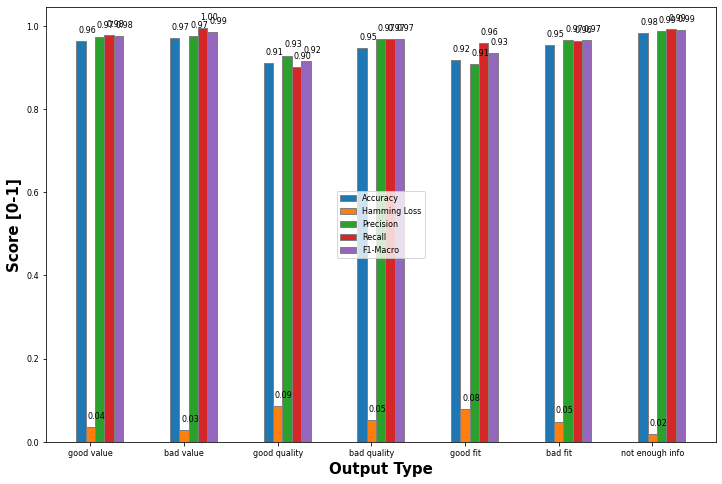

In [12]:
import matplotlib.pyplot as plt
import matplotlib
 
font = {'family' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
    
barWidth = 0.1
fig, ax = plt.subplots(figsize =(12, 8))

data_matrix_rot = np.array(data_matrix)

inf1 = data_matrix_rot[:, 0]
inf2 = data_matrix_rot[:, 1]
inf3 = data_matrix_rot[:, 2]
inf4 = data_matrix_rot[:, 3]
inf5 = data_matrix_rot[:, 4]
 
br1 = np.arange(data_matrix_rot.shape[0])
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]



plt.bar(br1, inf1, width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, inf2, width = barWidth,
        edgecolor ='grey', label ='Hamming Loss')
plt.bar(br3, inf3, width = barWidth,
        edgecolor ='grey', label ='Precision')
plt.bar(br4, inf4, width = barWidth,
        edgecolor ='grey', label ='Recall')
plt.bar(br5, inf5, width = barWidth,
        edgecolor ='grey', label ='F1-Macro')

x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


plt.xlabel('Output Type', fontweight ='bold', fontsize = 15)
plt.ylabel('Score [0-1]', fontweight ='bold', fontsize = 15)
if include_info_col:
    plt.xticks([r + barWidth for r in range(7)],
            ['good value', 'bad value', 'good quality', 'bad quality', 'good fit', 'bad fit', 'not enough info'])
else:
    plt.xticks([r + barWidth for r in range(6)],
            ['good value', 'bad value', 'good quality', 'bad quality', 'good fit', 'bad fit'])

# Show 
plt.legend(loc="center")
plt.show()

In [13]:
for value, label in zip(np.mean(data_matrix_rot, axis=0), ["Accuracy", "Hamming Loss", "Precision", "Recall", "F1-Macro"]):
    print(label, "Mean:", value)                

Accuracy Mean: 0.9494328013843492
Hamming Loss Mean: 0.050278792539896186
Precision Mean: 0.9584746707911326
Recall Mean: 0.9657743909150237
F1-Macro Mean: 0.961980527022133


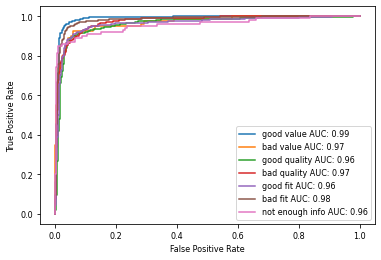

In [14]:
from sklearn import metrics
from scipy.stats import logistic

cleaned_data_act = dict(zip(raw_preds, map(logistic.cdf, raw_preds.values())))

activation_value = dict()
for label in cleaned_data_act:
    activation_value[label] = []
    for true_idx, value_set in zip(y_true[label], cleaned_data_act[label]):
        activation_value[label].append(value_set[1])

for label in y_true:
    fpr, tpr, _ = metrics.roc_curve(y_true[label].argmax(axis=1), activation_value[label])
    plt.plot(fpr, tpr, label=label + f" AUC: {round(metrics.auc(fpr, tpr), 2)}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plt.legend();

good value true count: 1398
bad value true count: 1415
good quality true count: 1289
bad quality true count: 1368
good fit true count: 1322
bad fit true count: 1367
not enough info true count: 1445


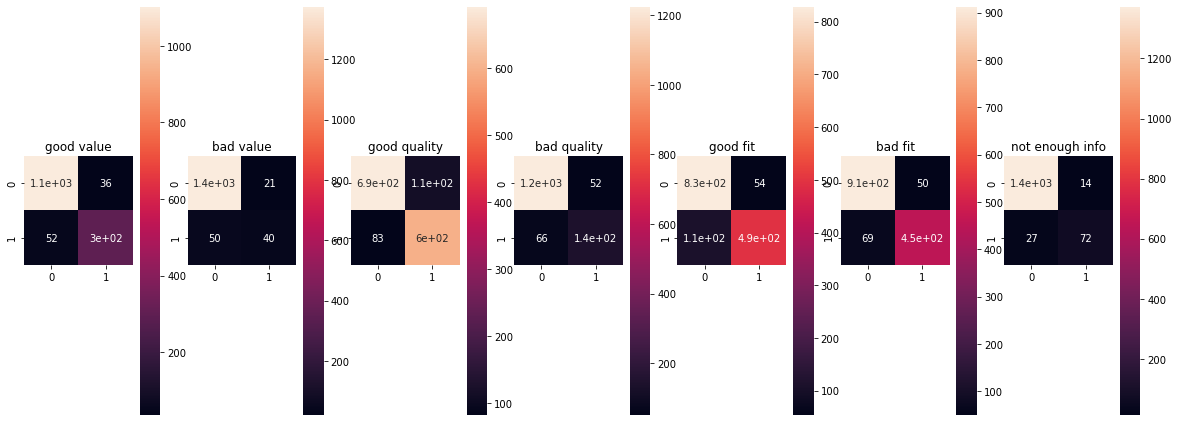

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(ncols=len(y_true.keys()), figsize=(20,10))

for idx, label in enumerate(y_true):
    axs[idx].set_title(label)
    confusion_mat = confusion_matrix(y_true[label].argmax(axis=1), cleaned_data_act[label].argmax(axis=1))
    sns.heatmap(confusion_mat, annot=True, 
                ax=axs[idx], square=True);
    print(label, "true count:", confusion_mat[0][0] + confusion_mat[1][1])

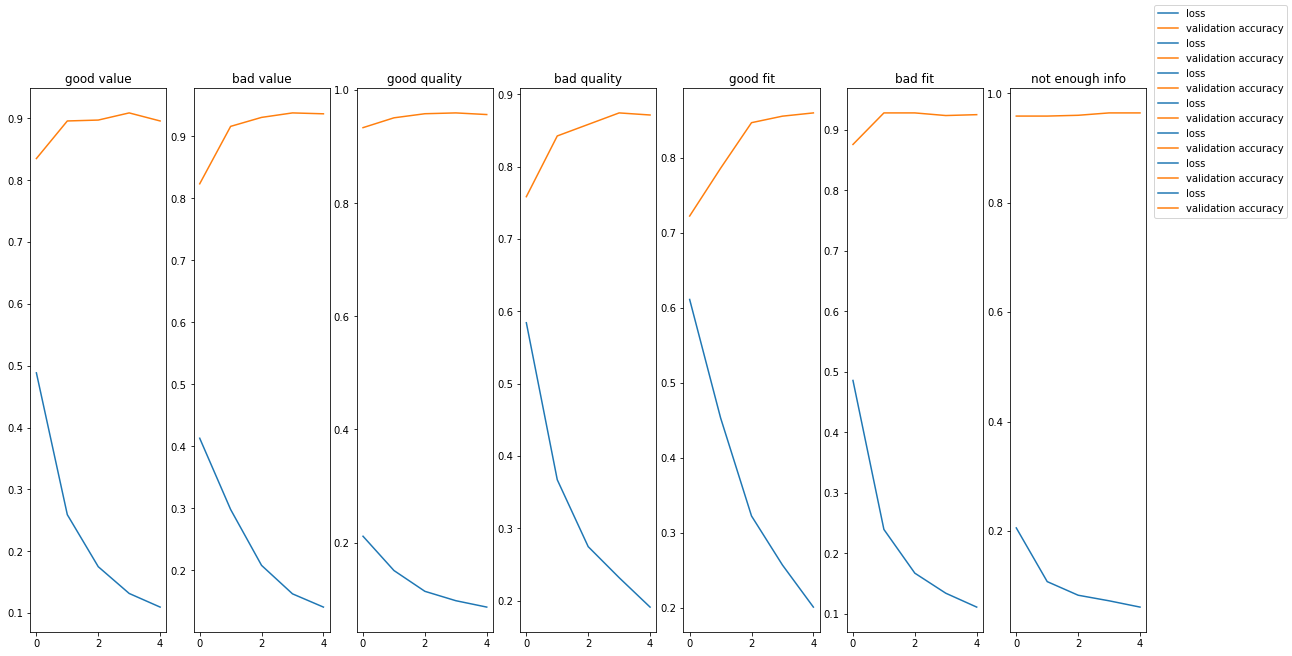

In [17]:
loss_arr = ['bad_fit_loss', 'bad_quality_loss', 'bad_value_loss', 'good_fit_loss', 'good_quality_loss', 'good_value_loss',
            'not_enough_info_loss']
val_arr  = ['val_bad_fit_accuracy', 'val_bad_quality_accuracy', 'val_bad_value_accuracy', 'val_good_fit_accuracy', 
            'val_good_quality_accuracy', 'val_good_value_accuracy', 'val_not_enough_info_accuracy']

fig, axs = plt.subplots(ncols=len(val_arr), figsize=(20,10))

for idx, (loss_dat, val_dat, label) in enumerate(zip(loss_arr, val_arr, y_true)):
    axs[idx].plot(history.history[loss_dat], label="loss")
    axs[idx].plot(history.history[val_dat], label="validation accuracy")
    axs[idx].set_title(label)
fig.legend();

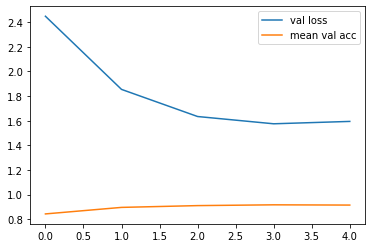

In [18]:
mean_val_acc = []
for idx in range(5):
    mean_mat = []
    for label in val_arr:
        mean_mat.append(history.history[label][idx])
    mean_val_acc.append(np.mean(mean_mat))
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(mean_val_acc, label="mean val acc")
plt.legend();